In [23]:
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


## Fig size 10,10
## subplot 2 by 2
## work on time series analysis for Net Income (and split by lower 4 banks)

In [10]:
df = pd.read_csv('../data/banks_data_1984.csv')

In [53]:
df.head()

,US100NUM,US13NUM,US31NUM,US115NUM,USG15NUM,US100NIM,US13NIM,US31NIM,US115NIM,USG15NIM,...,US13LLRTL,US31LLRTL,US115LLRTL,USG15LLRTL,US100NPTL,US13NPTL,US31NPTL,US115NPTL,USG15NPTL,Tot_Num_Banks
DATE,,,,,,,,,,,,,,,,,,,,,
1984-01-01,12147,1563,436,237,17,4.62,4.30,4.26,3.72,3.04,...,1.16,1.20,1.32,1.08,2.66,2.27,2.35,2.99,3.93,14400
1984-04-01,12123,1558,445,240,17,4.70,4.43,4.44,3.84,3.06,...,1.14,1.19,1.28,1.15,2.55,2.13,2.18,2.73,4.17,14383
1984-07-01,12127,1553,449,243,17,4.72,4.49,4.49,3.91,3.08,...,1.16,1.21,1.30,1.16,2.61,2.20,2.10,2.76,3.83,14389
1984-10-01,12125,1559,447,243,17,4.69,4.46,4.50,3.97,3.18,...,1.20,1.19,1.31,1.23,2.60,2.16,2.03,2.60,3.78,14391
1985-01-01,11972,1670,459,263,17,4.63,4.39,4.39,3.92,3.38,...,1.23,1.23,1.35,1.27,3.02,2.36,2.15,2.64,3.88,14381


In [17]:
# Adding column that has total number of banks for a given quarter.

df['Tot_Num_Banks'] = df.US100NUM+df.US13NUM+df.US31NUM+df.US115NUM+df.USG15NUM

In [15]:
# Need to convert Date column info to datetime type.

df.DATE = pd.to_datetime(df.DATE, infer_datetime_format=True)

(141, 32)

In [19]:
# Make Date the index 
df.set_index('DATE', inplace = True)

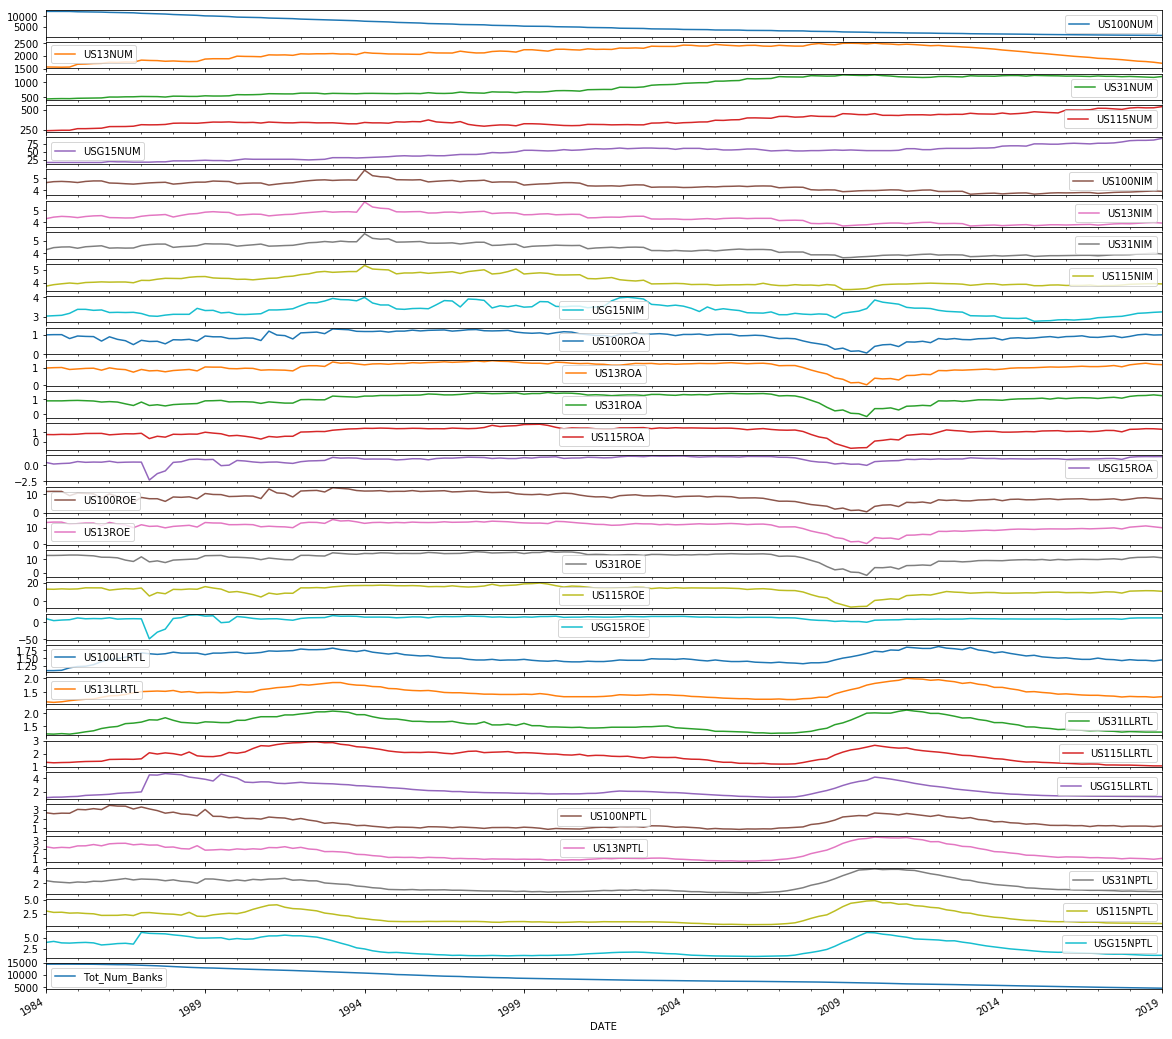

In [46]:
df.plot(figsize = (20,20), subplots=True, legend=True)
plt.show()

In [49]:
# Use pandas grouper to group values using annual frequency
year_groups = df.groupby(pd.Grouper(freq ='A'))

## Come back to this

Trying to see subplots of variable by year

In [51]:
df_annual = pd.DataFrame()

for yr, group in year_groups:
    #print(group.values)
    df_annual[yr.year] = group.values.ravel()

# Plot the yearly groups as subplots
# df_annual.plot(figsize = (22,15), subplots=True, legend=True)
# plt.show()

ValueError: Length of values does not match length of index

Moving on to seasonality and trend